# Cellular states identification using subcellularly informed representations

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from model.train import *
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.spatial.distance import cdist
from scipy.stats import wilcoxon 
import seaborn as sns
import networkx as nx


In [ ]:
data_path = './SVC/' 
dataset = 'data/merfish_U2OS' 
device = 'cuda:1'

In [3]:
gene_names = np.loadtxt(f'{data_path}{dataset}/gene_names.txt', dtype=str)
gene_names = gene_names.tolist()
cell_names = np.loadtxt(f'{data_path}{dataset}/cell_names.txt', dtype=str)

train_merfish_U2OS = np.load(f"{data_path}{dataset}/train_merfish_U2OS.npz")  
train_image = train_merfish_U2OS["data_ori"]
train_cell_morphology = train_merfish_U2OS["cell_morphology"]
train_nuclear_morphology = train_merfish_U2OS["nuclear_morphology"]
train_data_location = train_merfish_U2OS["location"]
train_cell_names = train_merfish_U2OS["cell_names"]
train_dataset = SVC_Dataset(
    data_ori=train_image,
    location=train_data_location,
    cell_morphology_vec=train_cell_morphology,
    nuclear_morphology_vec=train_nuclear_morphology,
)
print("number of training cells:", len(train_dataset),', number of genes:', train_image.shape[1])
train_count_sum = np.load(f'{data_path}output/merfish_U2OS/train_count_sum.npy')
read_dir =f'{data_path}{dataset}/gene2vec_weight_merfish_U2OS.npy'
gene2vec_weight = torch.from_numpy(np.load(read_dir)).float() ##n_gene * 200

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = False, num_workers = 4)

number of training cells: 900 , number of genes: 119


**load the trained model and extract latent representations**

In [4]:
ckpt_dir = f"{data_path}/checkpoints/"
ckpt = torch.load(ckpt_dir +'SVC_merfish_U2OS.pth', map_location=device)

state = ckpt.get("model_state_dict", ckpt)  
state = {k.removeprefix("module."): v for k, v in state.items()}

model = SVC(
    gene2vec_weight = gene2vec_weight,
    use_cell_identity = False,
).to(device)

model.load_state_dict(state)

all_embeddings_train = extract_latent_embeddings(
    model=model,
    loader=train_loader,
    use_cell_identity = False,
    device=device,
    return_tensor=True
)

all_embeddings_train_np = all_embeddings_train.detach().cpu().numpy()
# np.save(f"{data_path}/output/seqfish/embeddings_train.npy", all_embeddings_train_np)

**use SVC’s representations to detect cell states and cell-to-cell variability through cell clustering**

In [5]:
from sklearn.cluster import SpectralClustering
cosine_simi =  torch.bmm(all_embeddings_train, all_embeddings_train.transpose(1, 2)) / ((torch.norm(all_embeddings_train, dim=2, keepdim=True)) * (torch.norm(all_embeddings_train, dim=2, keepdim=True)).transpose(1, 2))  
n_cell = cosine_simi.shape[0]

dist = np.zeros((n_cell, n_cell))

for i in tqdm(range(n_cell)):
    cosine_simi_subset = cosine_simi[i+1:]
    matrix_diff = cosine_simi[i] - cosine_simi_subset
    distance = torch.norm(matrix_diff, p='fro', dim=(1, 2))
    dist[i, (i+1):] = dist[(i+1):,i] = distance.cpu().numpy()

sigma = np.median(dist) 
S = np.exp(-dist ** 2 / (2. * sigma ** 2))
clustering = SpectralClustering(n_clusters=4, affinity='precomputed', random_state=2025)
subcluster_labels = clustering.fit_predict(S)
# np.save(f"{data_path}output/merfish_U2OS/subcluster_labels.npy", subcluster_labels)

100%|██████████| 900/900 [00:00<00:00, 10212.08it/s]


**UMAP visualization**

In [6]:
import umap
reducer = umap.UMAP(random_state=0)
embeddings_cosine_UMAP = reducer.fit_transform(cosine_simi.cpu().reshape(cosine_simi.shape[0],-1))

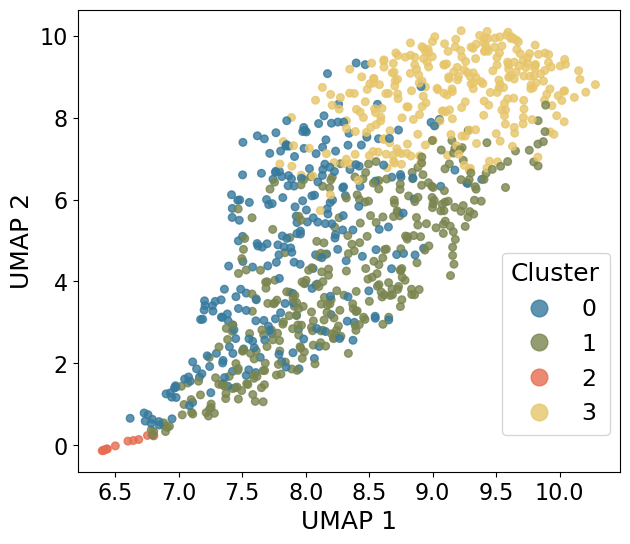

In [7]:
from matplotlib.colors import ListedColormap
class_names = [0,1,2,3]
custom_colors = ['#377A9D','#7A854F','#e66d50','#e7c66b']  
custom_map = ListedColormap(custom_colors)
plt.figure(figsize=(7,6))
ax = plt.scatter(embeddings_cosine_UMAP[:, 1], embeddings_cosine_UMAP[:, 0], alpha=0.8,s=30,c = subcluster_labels,cmap=custom_map)
handles, _ = ax.legend_elements()
plt.legend(handles, class_names, title="Cluster", bbox_to_anchor=(0.76, 0.5), loc='upper left', fontsize=17,title_fontsize=18,markerscale=2)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("UMAP 1", fontsize=18)
plt.ylabel("UMAP 2", fontsize=18)
# plt.savefig(f"{data_path}output/merfish_U2OS/figures/UMAP_cell_clusters.png", bbox_inches='tight', dpi=300,transparent=True)
plt.show()

cluster 2 forms a smaller, isolated group indicative of a distinct outlier population

**calculate relative distance to nuclear center as well as unspliced/spliced ratio for each gene**

In [8]:
truth_gene_dist = np.zeros((len(train_cell_names),len(gene_names)))
I = 0
for cell in range(len(train_cell_names)):
    cell_gene_real = train_image[cell]
    J = 0
    for gene in range(len(gene_names)):
        heatmap_real = cell_gene_real[gene,:,:,]
        truth_gene_dist[I,J] = compute_relative_dist_to_nuclear_center(heatmap_real)

        J += 1
    I += 1

In [ ]:

truth_gene_dist_mean_0 = np.nanmean(truth_gene_dist[subcluster_labels ==0],axis=0)
truth_gene_dist_mean_1 = np.nanmean(truth_gene_dist[subcluster_labels ==1],axis=0)
truth_gene_dist_mean_2 = np.nanmean(truth_gene_dist[subcluster_labels ==2],axis=0)
truth_gene_dist_mean_3 = np.nanmean(truth_gene_dist[subcluster_labels ==3],axis=0)
print("truth_gene_dist_mean_0:",np.median(truth_gene_dist_mean_0))
print("truth_gene_dist_mean_1:",np.median(truth_gene_dist_mean_1))
print("truth_gene_dist_mean_2:",np.median(truth_gene_dist_mean_2))
print("truth_gene_dist_mean_3:",np.median(truth_gene_dist_mean_3))

## wilcoxon test
_, p_value30_0 = wilcoxon(truth_gene_dist_mean_3, truth_gene_dist_mean_0, alternative='greater')
_, p_value31_0 = wilcoxon(truth_gene_dist_mean_3, truth_gene_dist_mean_1, alternative='greater')
_, p_value32_0 = wilcoxon(truth_gene_dist_mean_3, truth_gene_dist_mean_2, alternative='greater')
print("p_value0:",p_value30_0)
print("p_value1:",p_value31_0)
print("p_value2:",p_value32_0)

truth_gene_dist_mean_0: 0.5959493276579844
truth_gene_dist_mean_1: 0.5874538846669943
truth_gene_dist_mean_2: 0.5424065361933716
truth_gene_dist_mean_3: 0.597701242864299
p_value0: 3.637482550141077e-05
p_value1: 1.2348894881412727e-16
p_value2: 4.199437544475863e-16


In [10]:
spliced_unspliced = np.load(f"{data_path}{dataset}/splice_unsplice.npz")
spliced = spliced_unspliced["splice"]
unspliced = spliced_unspliced["unsplice"]
train_indices = [i for i, name in enumerate(cell_names) if name in train_cell_names]
train_spliced = spliced[train_indices]
train_unspliced = unspliced[train_indices]

In [11]:
US_ratio = np.log1p(train_unspliced)-(np.log1p(train_spliced))
US_ratio_0 = US_ratio[subcluster_labels ==0].mean(0)
US_ratio_1 = US_ratio[subcluster_labels ==1].mean(0)
US_ratio_2 = US_ratio[subcluster_labels ==2].mean(0)
US_ratio_3 = US_ratio[subcluster_labels ==3].mean(0)
print("US_ratio_0:",np.median(US_ratio_0))
print("US_ratio_1:",np.median(US_ratio_1))
print("US_ratio_2:",np.median(US_ratio_2)) 
print("US_ratio_3:",np.median(US_ratio_3))
_, p_value10_1 = wilcoxon(US_ratio_1, US_ratio_0, alternative='greater')
_, p_value20_1 = wilcoxon(US_ratio_2, US_ratio_0, alternative='greater')
_, p_value30_1 = wilcoxon(US_ratio_3, US_ratio_0, alternative='greater')
print("p_value0:",p_value10_1)
print("p_value1:",p_value20_1)
print("p_value2:",p_value30_1)

US_ratio_0: -0.6957653599787612
US_ratio_1: -0.626657226609145
US_ratio_2: -0.07188431899080086
US_ratio_3: -0.6196540992149764
p_value0: 2.202834250094225e-11
p_value1: 4.967700805576257e-19
p_value2: 8.322344443407937e-10


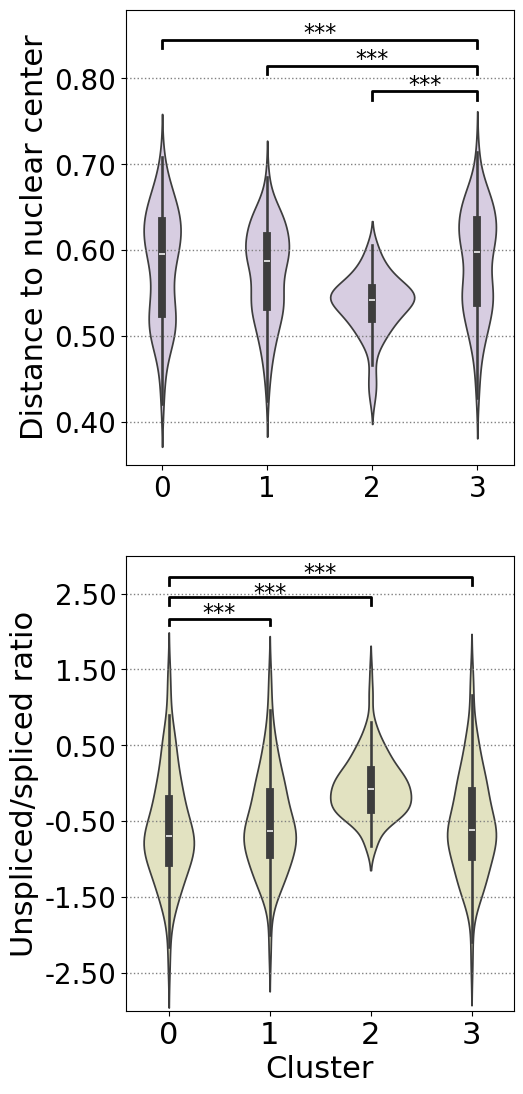

In [ ]:
def get_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'n.s.'  

fig, ax = plt.subplots(2, 1, figsize=(5, 13),  gridspec_kw={ "hspace": 0.2})
sns.violinplot([truth_gene_dist_mean_0, truth_gene_dist_mean_1, truth_gene_dist_mean_2, truth_gene_dist_mean_3], color='#D7CAE4',ax=ax[0]) #, width=0.5, linewidth=2, showfliers=False,zorder=10
ax[0].set_ylim(0.35,0.88)
# plt.xlim(-0.5,2.5)
ax[0].set_xticks([0,1,2,3], [0,1,2,3],fontsize=20)
ax[0].set_ylabel('Distance to nuclear center', fontsize=22)
ax[0].set_yticks(np.arange(0.4, 0.88, 0.1), ['0.40','0.50','0.60','0.70','0.80'],fontsize=20)
y_offset_inter = 0.05  
y_max = 0.795
fontprops = {'size': 16, 'ha': 'center'}
ax[0].plot([0,0,3,3], 
        [y_max - y_offset_inter+0.09,y_max - y_offset_inter+0.01+0.09,y_max - y_offset_inter+0.01+0.09, y_max - y_offset_inter+0.09], 
        color='black', lw=2, clip_on=False)
ax[0].text(1.5, y_max - y_offset_inter + 0.01+0.09, 
        get_stars(p_value30_0), 
        **fontprops)
ax[0].plot([1,1,3,3], 
        [y_max - y_offset_inter+0.06,y_max - y_offset_inter+0.01+0.06,y_max - y_offset_inter+0.01+0.06, y_max - y_offset_inter+0.06], 
        color='black', lw=2, clip_on=False)
ax[0].text(2, y_max - y_offset_inter+0.06 + 0.01, 
        get_stars(p_value31_0), 
        **fontprops)
ax[0].plot([2,2,3,3], 
        [y_max - y_offset_inter+0.03,y_max - y_offset_inter+0.01+0.03,y_max - y_offset_inter+0.01+0.03, y_max - y_offset_inter+0.03], 
        color='black', lw=2, clip_on=False)
ax[0].text(2.5, y_max - y_offset_inter +0.03 + 0.01, 
        get_stars(p_value32_0), 
        **fontprops)
ax[0].grid(axis='y', color='gray', linestyle=':',linewidth=1)

sns.violinplot([US_ratio_0, US_ratio_1, US_ratio_2, US_ratio_3], color='#e8e7bb',ax=ax[1]) #, width=0.5, linewidth=2, showfliers=False,zorder=10
plt.ylim(-3,3)

plt.xticks([0,1,2,3], fontsize=22)
ax[1].set_xlabel('Cluster', fontsize=22)
ax[1].set_ylabel('Unspliced/spliced ratio', fontsize=22)
y_offset_inter = 0.05  # 组间标注垂直偏移
y_max = 2.15
fontprops = {'size': 16, 'ha': 'center'}
ax[1].plot([0,0,1,1], 
        [y_max - y_offset_inter-0.01,y_max - y_offset_inter+0.07-0.01,y_max - y_offset_inter+0.07-0.01, y_max - y_offset_inter-0.01], 
        color='black', lw=2, clip_on=False)
ax[1].text(0.5, y_max - y_offset_inter + 0.05+0.01, 
        get_stars(p_value10_1), 
        **fontprops)
ax[1].plot([0,0,2,2], 
        [y_max - y_offset_inter+0.25,y_max - y_offset_inter+0.25+0.1,y_max - y_offset_inter+0.25+0.1, y_max - y_offset_inter+0.25], 
        color='black', lw=2, clip_on=False)
ax[1].text(1, y_max - y_offset_inter + 0.32, 
        get_stars(p_value20_1), 
        **fontprops)
ax[1].plot([0,0,3,3], 
        [y_max - y_offset_inter+0.52,y_max - y_offset_inter+0.52+0.1,y_max - y_offset_inter+0.52+0.1, y_max - y_offset_inter+0.52], 
        color='black', lw=2, clip_on=False)
ax[1].text(1.5, y_max - y_offset_inter + 0.52+0.07, 
        get_stars(p_value30_1), 
        **fontprops)
ax[1].grid(axis='y', color='gray', linestyle=':',linewidth=1)
ax[1].set_yticks(np.arange(-2.5,2.8,1), ['-2.50','-1.50','-0.50','0.50','1.50','2.50'],fontsize=20)
plt.show()

**compare marker gene expression**

G2M marker gene: CKAP5
S marker gene: BRCA2


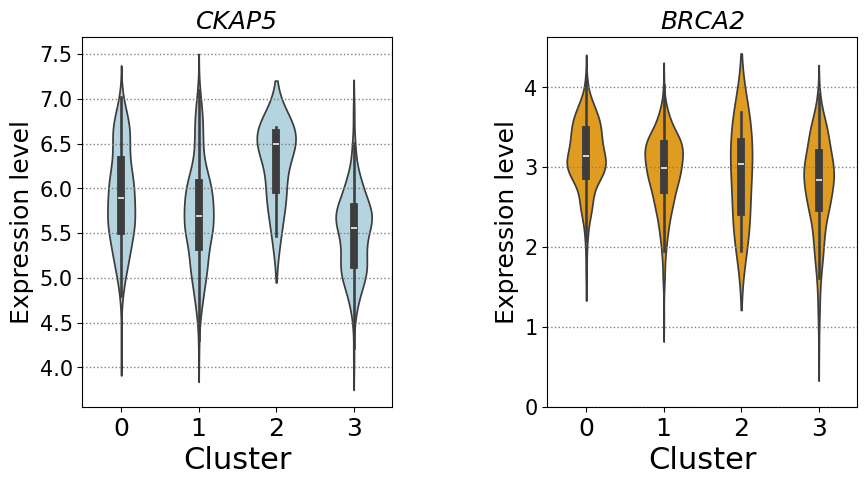

In [13]:

exp_level = train_image.sum((2,3))
fig, ax = plt.subplots(1, 2, figsize=(10, 4.8),  gridspec_kw={ "wspace": 0.5})
marker_gene_G2M ='CKAP5'
exp_level_0, exp_level_1, exp_level_2, exp_level_3 = [np.array(exp_level[subcluster_labels ==i][:,gene_names.index(marker_gene_G2M)]) for i in range(4)]
print("G2M marker gene:",marker_gene_G2M)
sns.violinplot([np.log1p(exp_level_0),np.log1p(exp_level_1),np.log1p(exp_level_2),np.log1p(exp_level_3)], color='lightblue', width=0.5,ax=ax[0])
ax[0].set_title(f"{marker_gene_G2M}",fontsize=18,fontstyle='italic')

marker_gene_S ='BRCA2'
exp_level_0, exp_level_1, exp_level_2, exp_level_3 = [np.array(exp_level[subcluster_labels ==i][:,gene_names.index(marker_gene_S)]) for i in range(4)]
print("S marker gene:",marker_gene_S)
sns.violinplot([np.log1p(exp_level_0),np.log1p(exp_level_1),np.log1p(exp_level_2),np.log1p(exp_level_3)], color='orange', width=0.5,ax=ax[1])
ax[1].set_title(f"{marker_gene_S}",fontsize=18,fontstyle='italic')

ax[0].set_xticks([0,1,2,3], [0,1,2,3],fontsize=18)
ax[0].set_yticks(np.arange(4, 8,0.5), ['4.0','4.5','5.0','5.5','6.0','6.5','7.0','7.5'],fontsize=15)
ax[0].grid(axis='y', color='gray', linestyle=':',linewidth=1)
ax[0].set_xlabel('Cluster', fontsize=22)
ax[0].set_ylabel('Expression level', fontsize=18)
ax[1].set_xticks([0,1,2,3], [0,1,2,3],fontsize=18)
ax[1].set_yticks(np.arange(0, 5, 1), ['0','1','2','3','4'],fontsize=15)
ax[1].grid(axis='y', color='gray', linestyle=':',linewidth=1)
ax[1].set_xlabel('Cluster', fontsize=22)

ax[1].set_ylabel('Expression level', fontsize=18)
plt.show()

cells in cluster 2 exhibit concentrated nuclear-peripheral transcript localization and a markedly elevated unspliced/spliced ratio, while also displaying increased CKAP5 expression

**calculate gene colocalization score for each cluster based on pairwise distances of each gene pair within cells**

In [14]:
gene_colocal_score_all = np.zeros((4, len(gene_names), len(gene_names)))
for i in range(4):
    embeddings_train_cell_cycle_i = all_embeddings_train_np[subcluster_labels == i]
    train_count_sum  = train_image[subcluster_labels == i].sum(axis=(-1,-2))
    gene_colocal_score = cal_gene_colocal_score(embeddings_train_cell_cycle_i, gene_names, train_count_sum)
    
    gene_colocal_score_all[i] = gene_colocal_score

100%|██████████| 289/289 [00:01<00:00, 240.95it/s]


**extract and compare top 30 co-localized gene pairs for each cluster** 

In [15]:
gene_pairs_30 = []

for i in range(4):

    upper_triangle = np.triu(gene_colocal_score_all[i])
    gene_pairs_30_cluster_i = []

    for j in range(30):

        idx1,idx2 = np.where(upper_triangle == np.max(upper_triangle))
        idx1,idx2 = idx1[0],idx2[0]
        gene_pairs_30_cluster_i.append((gene_names[idx1],gene_names[idx2]))
        upper_triangle[idx1,idx2] = 0

    gene_pairs_30.append(gene_pairs_30_cluster_i)

print(gene_pairs_30[0])
print(gene_pairs_30[1])
print(gene_pairs_30[2])
print(gene_pairs_30[3])

[('LRP1', 'THBS1'), ('NOTCH2', 'THBS1'), ('PRPF8', 'TLN1'), ('FBN2', 'THBS1'), ('COL5A1', 'THBS1'), ('FASN', 'TLN1'), ('COL5A1', 'LRP1'), ('IGF2R', 'THBS1'), ('FBN2', 'LRP1'), ('LRP1', 'NOTCH2'), ('COL5A1', 'FBN2'), ('COL5A1', 'NOTCH2'), ('FASN', 'PRPF8'), ('IGF2R', 'LRP1'), ('PLXNA1', 'THBS1'), ('FBN2', 'NOTCH2'), ('IGF2R', 'NOTCH2'), ('TLN1', 'USP9X'), ('FBN2', 'IGF2R'), ('COL5A1', 'IGF2R'), ('PRKDC', 'TLN1'), ('SRRM2', 'TNRC6A'), ('CKAP5', 'TLN1'), ('NOTCH2', 'PLXNA1'), ('CKAP5', 'FASN'), ('CREBBP', 'TLN1'), ('PRPF8', 'USP9X'), ('COL5A1', 'PLXNA1'), ('LMTK2', 'THBS1'), ('LRP1', 'PLXNA1')]
[('NOTCH2', 'THBS1'), ('LRP1', 'THBS1'), ('PRPF8', 'TLN1'), ('COL5A1', 'THBS1'), ('FASN', 'TLN1'), ('FBN2', 'THBS1'), ('PRKDC', 'TLN1'), ('IGF2R', 'THBS1'), ('TLN1', 'USP9X'), ('LRP1', 'NOTCH2'), ('COL5A1', 'NOTCH2'), ('COL5A1', 'LRP1'), ('FASN', 'PRKDC'), ('PLXNA1', 'THBS1'), ('FBN2', 'NOTCH2'), ('FASN', 'PRPF8'), ('FBN2', 'LRP1'), ('SPTBN1', 'TLN1'), ('CKAP5', 'TLN1'), ('PRKDC', 'PRPF8'), ('SRRM2

In [16]:
gene_pair_label = []
union_pair= set(gene_pairs_30[0]) | set(gene_pairs_30[1]) | set(gene_pairs_30[2]) | set(gene_pairs_30[3])
union_pair = list(union_pair)
for i in union_pair:
    gene_pair_label_i = []
    if i in gene_pairs_30[0]:
        gene_pair_label_i.append('Cluster 0')
    if i in gene_pairs_30[1]:
        gene_pair_label_i.append('Cluster 1')
    if i in gene_pairs_30[2]:
        gene_pair_label_i.append('Cluster 2')
    if i in gene_pairs_30[3]:
        gene_pair_label_i.append('Cluster 3')
    gene_pair_label.append(gene_pair_label_i)


In [17]:
cluster_0_specific_pair, cluster_1_specific_pair, cluster_2_specific_pair, cluster_3_specific_pair = [], [], [], [] 
for i in gene_pair_label:     
    if i == ['Cluster 0']:         
        cluster_0_specific_pair.append(i)     
    if i == ['Cluster 1']:         
        cluster_1_specific_pair.append(i)     
    if i == ['Cluster 2']:         
        cluster_2_specific_pair.append(i)     
    if i == ['Cluster 3']:         
        cluster_3_specific_pair.append(i) 
print("number of cluster 0/1/2/3 specific pairs:", len(cluster_0_specific_pair), len(cluster_1_specific_pair), len(cluster_2_specific_pair), len(cluster_3_specific_pair)) 

number of cluster 0/1/2/3 specific pairs: 2 2 16 0


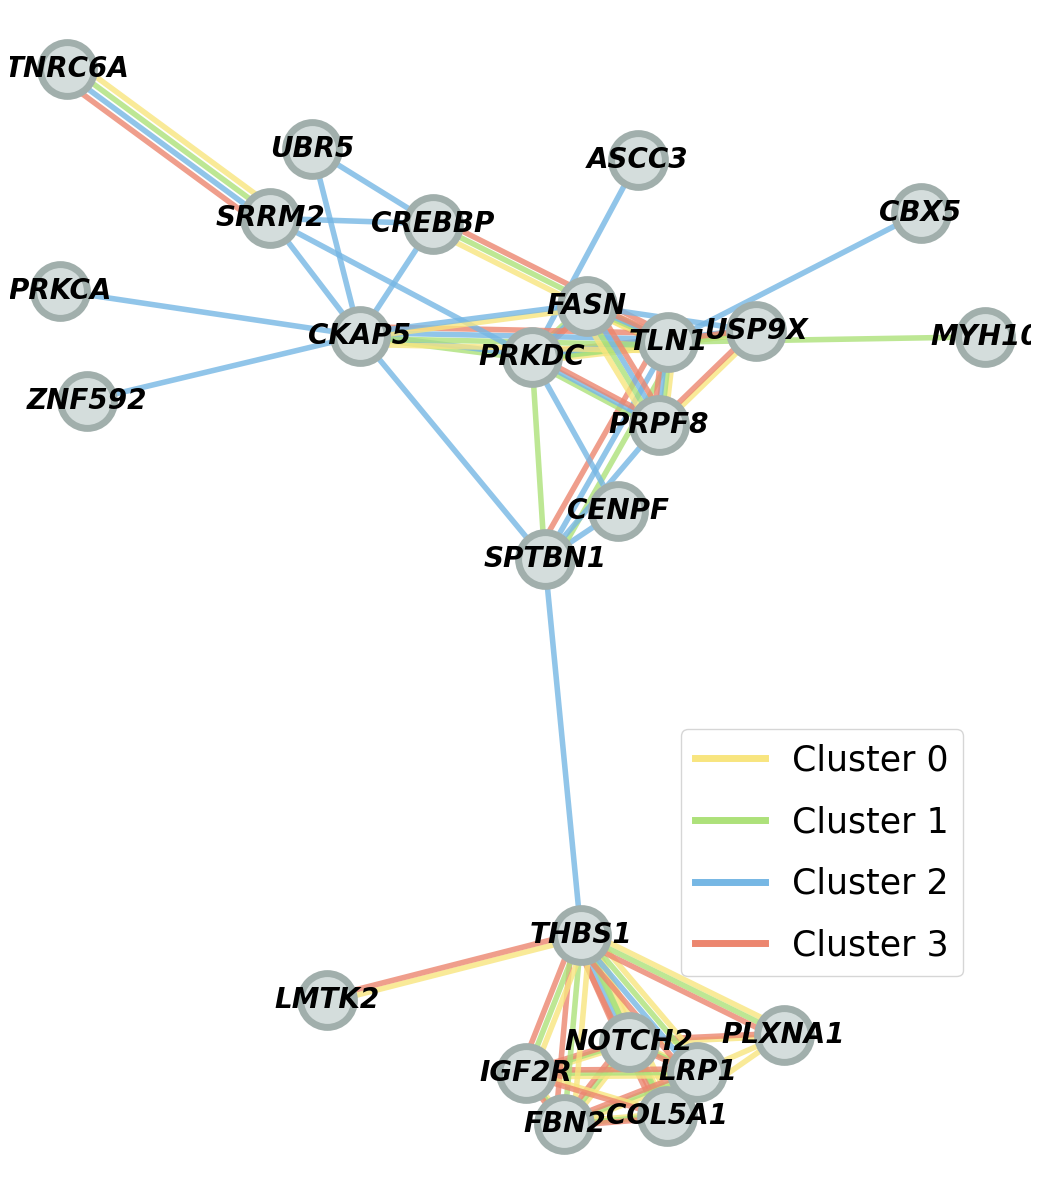

In [ ]:

G = nx.Graph()
G.add_edges_from(union_pair)

components = list(nx.connected_components(G))
G_sub = G.subgraph(components[0]).copy()

edge_to_labels = {}
for e, labs in zip(union_pair, gene_pair_label):
    if e not in G_sub.edges:
        continue

    if isinstance(labs, str):
        labs_list = [x.strip() for x in labs.split(";")]
    else:
        labs_list = list(labs)

    if e not in edge_to_labels:
        edge_to_labels[e] = []

    for lab in labs_list:
        edge_to_labels[e].append(lab)

unique_labels = ['Cluster 0','Cluster 1', 'Cluster 2', 'Cluster 3']
colors = ['#F8E57F','#ADE17A','#76B7E4','#EC866F']
label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}

pos = nx.spring_layout(G_sub, k=0.4, iterations=100, seed=1234) 
fig, ax = plt.subplots(figsize=(13, 12))

for (u, v), labs_list in edge_to_labels.items():
    labs_list = [lab for lab in labs_list if lab in unique_labels]
    if len(labs_list) == 0:
        continue

    x1, y1 = pos[u]
    x2, y2 = pos[v]

    dx = x2 - x1
    dy = y2 - y1
    length = np.hypot(dx, dy) + 1e-9  

    nx_perp = -dy / length
    ny_perp = dx / length

    m = len(labs_list)
    base = 0.03 
    if m == 1:
        offsets = [0.0]
    else:
        offsets = [(i - (m - 1) / 2) * base for i in range(m)]

    for lab, off in zip(labs_list, offsets):
        ox = nx_perp * off * length
        oy = ny_perp * off * length

        ax.plot(
            [x1 + ox, x2 + ox],
            [y1 + oy, y2 + oy],
            color=label_to_color[lab],
            linewidth=4,
            alpha=0.8,
        )

nx.draw_networkx_nodes(G_sub, pos, node_color='#D4DDDC', node_size=1500, ax=ax, edgecolors = '#A1AFAC',linewidths=5)
texts = nx.draw_networkx_labels(
    G_sub, pos,
    font_size=20,
    font_color="black",
    font_weight="bold",
    ax=ax
)

for t in texts.values():
    t.set_fontstyle("italic")   

handles = [Line2D([0], [0], color=label_to_color[l], lw=5) for l in unique_labels]
ax.legend(handles, unique_labels, fontsize=25, bbox_to_anchor=(0.95, 0.4), ncol=1,labelspacing=0.8)

ax.set_axis_off()
plt.tight_layout()
plt.show()


the co-localization pattern of cluster 2 is distinct from the others